In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL
import scipy.ndimage as ndimage
import glob
import os

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_model_optimization as tfmot
#import tensorflow_datasets as tfds
import random
import shutil
from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

2024-06-11 17:40:29.364744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 17:40:29.364819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 17:40:29.433110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 17:40:29.579339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def path_to_fen(path):
    filename = os.path.basename(path).split('.')[0]
    fen = filename.replace('-', '/')
    return fen

def get_dataset(prefix):
    files = glob.glob(prefix)
    fen = [path_to_fen(path) for path in files]
    return pd.DataFrame({'fen': fen, 'path': files})

digits = {'0', '1', '2', '3', '4', '5', '6', '7', '8'}
def decompress_fen(fen):
    return ''.join([
        ' ' * int(ch) if ch in digits else ch
        for ch in fen
    ]).split('/')

train = get_dataset('./dataset/train/*')
test = get_dataset('/tf/test/*')
train

,fen,path
0,1b1B1b2/2pK2q1/4p1rB/7k/8/8/3B4/3rb3,./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B...
1,1b1b1b2/3r4/1rK4b/R7/R2R1k2/2Bp4/2P5/2r5,./dataset/train/1b1b1b2-3r4-1rK4b-R7-R2R1k2-2B...
2,1B1B1K2/3p1N2/6k1/R7/5P2/4q3/7R/1B6,./dataset/train/1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7...
3,1b1B1K2/R2B4/7P/3b4/3R2B1/8/3R4/4Qk2,./dataset/train/1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R...
4,1b1b1n2/1K1RN1b1/3pbN2/8/4q1k1/4P3/8/2n3N1,./dataset/train/1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1...
...,...,...
79995,rr4N1/5n2/8/pq3Bk1/1N6/8/2KP4/8,./dataset/train/rr4N1-5n2-8-pq3Bk1-1N6-8-2KP4-...
79996,Rr4Q1/2b5/R1K5/7B/6n1/6q1/R3p1N1/5Rk1,./dataset/train/Rr4Q1-2b5-R1K5-7B-6n1-6q1-R3p1...
79997,rr4rk/1K2N3/8/q7/1n2N3/8/N1Q5/8,./dataset/train/rr4rk-1K2N3-8-q7-1n2N3-8-N1Q5-...
79998,rR4RN/p7/3BR3/8/K7/1B1pB3/1r2k3/B3r3,./dataset/train/rR4RN-p7-3BR3-8-K7-1B1pB3-1r2k...


## Eval functions

In [3]:
def load_image(filename, format='L'):
    img = PIL.Image.open(filename)
    bw = img.convert(format)
    img_array = np.asarray(bw)
    return img_array

def segment_image(img, n=8):
    return np.array(np.split(np.array(np.split(img, n, 1)), n, 1))

def resize_tile(tile, size=25):
    img = PIL.Image.fromarray(tile)
    img = img.resize((size, size))
    return np.asarray(img)

def compress_dfen(dfen):
    empty_counter = 0
    out = ''
    for char in dfen:
        if char == ' ':
            empty_counter += 1
        else:
            if empty_counter != 0:
                out += str(empty_counter)
                empty_counter = 0
            out += char
    if empty_counter != 0:
        out += str(empty_counter)
        empty_counter = 0
    return out

figure_lut = np.array(['B', ' ', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r'])
def generate_fen_from_picture(path, figure_lut=figure_lut, rowSep='/'):
    img = load_image(path)
    tiles = segment_image(img)
    # (8,8,W,H) -> (64,W,H) so tensorflow can process it in a batch
    tiles = tiles.reshape(64, tiles.shape[2], tiles.shape[3])
    res = model.predict(tiles, verbose=False)
    ids = np.argmax(res, 1)
    chars = figure_lut[ids].reshape(8,8)
    decompressed_fen = '/'.join(''.join(row) for row in chars)
    fen = compress_dfen(decompressed_fen)
    return fen

# Print errors as they come up
def continous_eval(df, *args, ret_on_fail=False, **kwargs):
    error_counter = 0
    outputs = []
    for row in df.iterrows():
        (_, (fen, path)) = row
        pred = generate_fen_from_picture(path, *args, **kwargs)
        outputs.append(pred)
        if pred != fen:
            error_counter += 1
            print(f'Error {error_counter}.')
            print(f'True: {fen}')
            print(f'Pred: {pred}')
            if ret_on_fail:
                return 
    return pd.Series(outputs)

color_lut=np.array(['b', 'W'])
def generate_colors_from_picture(path, model=probability_model, color_lut=color_lut, rowSep='/', thresh=0.5):
    img = load_image(path)
    tiles = segment_image(img)
    # (8,8,W,H) -> (64,W,H) so tensorflow can process it in a batch
    tiles = tiles.reshape(64, tiles.shape[2], tiles.shape[3])
    res = model.predict(tiles, verbose=False).ravel()
    chars = color_lut[(res>thresh).astype(int)].reshape(8,8)
    str = '/'.join(''.join(row) for row in chars)
    return str

def continous_eval_color(df, *args, ret_on_fail=False, **kwargs):
    error_counter = 0
    outputs = []
    for row in df.iterrows():
        (id, (fen, path)) = row
        pred = generate_colors_from_picture(path, *args, **kwargs)
        dfen = '/'.join(decompress_fen(fen))
        for i in range(len(dfen)):
            if not dfen[i].isalpha():
                continue
            if dfen[i].isupper() != pred[i].isupper():
                error_counter += 1
                print(f'Error {error_counter} at {id}[{i}] ({dfen[i].isupper()}/{pred[i].isupper()})')
                outputs.append(False)
                if ret_on_fail:
                    return
            else:
                outputs.append(True)
    return pd.Series(outputs)

piece_test = test.copy()
piece_test.fen = piece_test.fen.str.upper()

## Dataset functions

In [4]:
def load_dataset(src_folder, label_mode='int', batch_size=256, image_size=(50,50)):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        src_folder,
        label_mode=label_mode,
        validation_split=0.2,
        subset="training",
        seed=123,
        color_mode='grayscale',
        image_size=image_size,
        batch_size=batch_size,
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        src_folder,
        label_mode=label_mode,
        validation_split=0.2,
        subset="validation",
        seed=123,
        color_mode='grayscale',
        image_size=image_size,
        batch_size=batch_size,
    )
    
    class_names = train_ds.class_names
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

COLOR_PATH = '/tf/dataset_color_only_sampled/'
FIGURE_PATH = '/tf/dataset_figures_only_sampled/'
BOTH_PATH = '/tf/dataset_pieces_sampled/'

## Custom Layers

In [5]:
@tf.keras.saving.register_keras_serializable()
class SplitFlipAdd(tf.keras.layers.Layer):
    def __init__(self, axis=2, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        first, second = tf.split(inputs, 2, axis=self.axis)
        second_flipped = tf.image.flip_left_right(second) if self.axis == 2 else tf.image.flip_up_down(second)
        summed = first + second_flipped
        return summed

    def get_config(self):
        config = super().get_config()
        config.update({
            "axis": self.axis,
        })
        return config

@tf.keras.saving.register_keras_serializable()
class Segmenter2DWithModels(tfmot.sparsity.keras.PrunableLayer, tf.keras.layers.Layer):
    def __init__(self, segment_count_x, segment_count_y, models, **kwargs):
        super(Segmenter2DWithModels, self).__init__(**kwargs)
        self.segment_count_x = segment_count_x
        self.segment_count_y = segment_count_y
        self.models = models

    def call(self, inputs):
        segment_height = inputs.shape[1]//self.segment_count_y
        segment_width = inputs.shape[2]//self.segment_count_x
        segments = tf.image.extract_patches(
            images=inputs,
            sizes=[1, segment_height, segment_width, 1],
            strides=[1, segment_height, segment_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        model_res = [self.models[y][x](segments[:,y,x]) for y in range(self.segment_count_y) for x in range(self.segment_count_x)] 
        return tf.concat(model_res, axis=1)

    def get_prunable_weights(self):
        prunable_weights = [self.models[y][x].kernel for y in range(self.segment_count_y) for x in range(self.segment_count_x)] 
        return prunable_weights
    
    def get_config(self):
        config = super(Segmenter2DWithModels, self).get_config()
        config.update({
            "segment_count_x": self.segment_count_x,
            "segment_count_y": self.segment_count_y,
            "models": self.models,
        })
        return config


## Best color model pruning

In [58]:
train_ds, val_ds, class_names = load_dataset(COLOR_PATH, label_mode='binary')
list(enumerate(class_names))

Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.


[(0, 'class_black'), (1, 'class_white')]

In [168]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.CenterCrop(26,22),
    SplitFlipAdd(axis=2),
    SplitFlipAdd(axis=1),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(1e-6))
])

model.load_weights('./saved_models/l1_cropped_2sfa_color_perceptron.h5')

In [169]:
pruning_epochs=30
BATCH_SIZE = 256
end_step = np.ceil(96000 / BATCH_SIZE).astype(np.int32) * pruning_epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning(layer):
    if isinstance(layer, keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif isinstance(layer, Segmenter2DWithModels):
        layer.models = [tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params) for model in layer.models]
    return layer

model_for_pruning = keras.models.clone_model(
    model,
    clone_function=apply_pruning,
)

model_for_pruning.compile(
    optimizer=keras.optimizers.AdamW(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model_for_pruning.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    epochs=pruning_epochs+25,
)

Epoch 1/55
375/375 [==============================] - 3s 4ms/step - loss: 4.4778e-04 - accuracy: 1.0000 - val_loss: 4.8591e-04 - val_accuracy: 1.0000
Epoch 2/55
375/375 [==============================] - 1s 3ms/step - loss: 4.4493e-04 - accuracy: 1.0000 - val_loss: 4.7762e-04 - val_accuracy: 1.0000
Epoch 3/55
375/375 [==============================] - 1s 3ms/step - loss: 4.4336e-04 - accuracy: 1.0000 - val_loss: 4.7349e-04 - val_accuracy: 1.0000
Epoch 4/55
375/375 [==============================] - 1s 3ms/step - loss: 4.4394e-04 - accuracy: 1.0000 - val_loss: 5.7954e-04 - val_accuracy: 1.0000
Epoch 5/55
375/375 [==============================] - 1s 3ms/step - loss: 4.5082e-04 - accuracy: 1.0000 - val_loss: 4.7192e-04 - val_accuracy: 1.0000
Epoch 6/55
375/375 [==============================] - 1s 3ms/step - loss: 4.5103e-04 - accuracy: 1.0000 - val_loss: 4.7325e-04 - val_accuracy: 1.0000
Epoch 7/55
375/375 [==============================] - 1s 3ms/step - loss: 4.6964e-04 - accuracy: 1.0

In [170]:
model_for_pruning.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    epochs=50,
)

Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 7.3405e-04 - accuracy: 1.0000 - val_loss: 8.1928e-04 - val_accuracy: 0.9999
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 7.3122e-04 - accuracy: 1.0000 - val_loss: 8.1590e-04 - val_accuracy: 0.9999
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 7.2844e-04 - accuracy: 1.0000 - val_loss: 8.1258e-04 - val_accuracy: 0.9999
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 7.2571e-04 - accuracy: 1.0000 - val_loss: 8.0933e-04 - val_accuracy: 0.9999
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 7.2303e-04 - accuracy: 1.0000 - val_loss: 8.0613e-04 - val_accuracy: 0.9999
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 7.2039e-04 - accuracy: 1.0000 - val_loss: 8.0300e-04 - val_accuracy: 0.9999
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 7.1779e-04 - accuracy: 1.0

In [171]:
model_for_pruning.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    epochs=50,
)

Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 6.3053e-04 - accuracy: 1.0000 - val_loss: 6.9969e-04 - val_accuracy: 1.0000
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 6.2898e-04 - accuracy: 1.0000 - val_loss: 6.9796e-04 - val_accuracy: 1.0000
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 6.2744e-04 - accuracy: 1.0000 - val_loss: 6.9624e-04 - val_accuracy: 1.0000
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 6.2594e-04 - accuracy: 1.0000 - val_loss: 6.9460e-04 - val_accuracy: 1.0000
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 6.2450e-04 - accuracy: 1.0000 - val_loss: 6.9298e-04 - val_accuracy: 1.0000
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 6.2308e-04 - accuracy: 1.0000 - val_loss: 6.9137e-04 - val_accuracy: 1.0000
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 6.2166e-04 - accuracy: 1.0

In [172]:
continous_eval_color(test, model_for_pruning, ret_on_fail=True)

2024-06-11 15:51:40.316364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_36/center_crop_30/cond/branch_executed/_9


0         True
1         True
2         True
3         True
4         True
          ... 
199651    True
199652    True
199653    True
199654    True
199655    True
Length: 199656, dtype: bool

In [173]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()
model_for_export.save('./saved_models/color_pruned75.h5')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_30 (CenterCrop  (None, 26, 22, 1)         0         
 )                                                               
                                                                 
 split_flip_add_62 (SplitFl  (None, 26, 11, 1)         0         
 ipAdd)                                                          
                                                                 
 split_flip_add_63 (SplitFl  (None, 13, 11, 1)         0         
 ipAdd)                                                          
                                                                 
 rescaling_32 (Rescaling)    (None, 13, 11, 1)         0         
                                                                 
 flatten_30 (Flatten)        (None, 143)               0         
                                                     

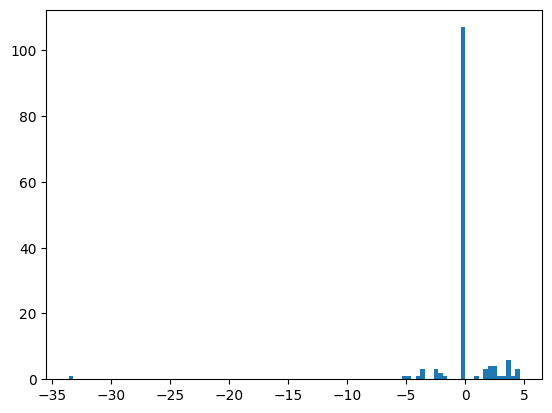

In [69]:
ws = model_for_export.get_weights()
ws = np.concatenate([w.ravel() for w in ws])
plt.hist(ws, bins=100)
plt.show()

## Best figure model pruning

In [7]:
train_ds, val_ds, class_names = load_dataset(FIGURE_PATH)
list(enumerate(class_names))

Found 140000 files belonging to 7 classes.
Using 112000 files for training.
Found 140000 files belonging to 7 classes.
Using 28000 files for validation.


[(0, 'class_b'),
 (1, 'class_empty'),
 (2, 'class_k'),
 (3, 'class_n'),
 (4, 'class_p'),
 (5, 'class_q'),
 (6, 'class_r')]

In [51]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    Segmenter2DWithModels(2, 4, [
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(4, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(3, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(3, activation='relu')],
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.load_weights('./saved_models/l1_sfa_segencoder.h5')

In [52]:
pruning_epochs=15
BATCH_SIZE = 256
end_step = np.ceil(112000 / BATCH_SIZE).astype(np.int32) * pruning_epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.40,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning(layer):
    if isinstance(layer, keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif isinstance(layer, Segmenter2DWithModels):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

model_for_pruning = keras.models.clone_model(
    model,
    clone_function=apply_pruning,
)

model_for_pruning.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=5e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_for_pruning.summary()

model_for_pruning.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    epochs=pruning_epochs+10,
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_6 (SplitFli  (None, 50, 25, 1)         0         
 pAdd)                                                           
                                                                 
 rescaling_6 (Rescaling)     (None, 50, 25, 1)         0         
                                                                 
 prune_low_magnitude_segmen  (None, 15)                4344      
 ter2d_with_models_6 (Prune                                      
 LowMagnitude)                                                   
                                                                 
 prune_low_magnitude_dense_  (None, 7)                 219       
 62 (PruneLowMagnitude)                                          
                                                                 
Total params: 4563 (17.83 KB)
Trainable params: 2287 (

In [53]:
continous_eval(piece_test, model_for_pruning, ret_on_fail=True)

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [54]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()
model_for_export.save('./saved_models/figure_pruned40.keras')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_6 (SplitFli  (None, 50, 25, 1)         0         
 pAdd)                                                           
                                                                 
 rescaling_6 (Rescaling)     (None, 50, 25, 1)         0         
                                                                 
 segmenter2d_with_models_6   (None, 15)                2175      
 (Segmenter2DWithModels)                                         
                                                                 
 dense_62 (Dense)            (None, 7)                 112       
                                                                 
Total params: 2287 (8.93 KB)
Trainable params: 2287 (8.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


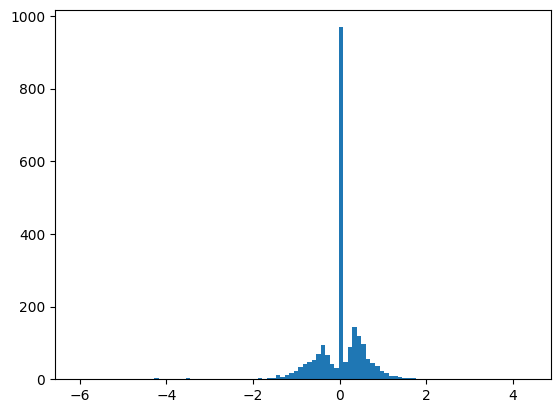

In [57]:
ws = model_for_export.get_weights()
ws = np.concatenate([w.ravel() for w in ws])
plt.hist(ws, bins=100)
plt.show()

## End